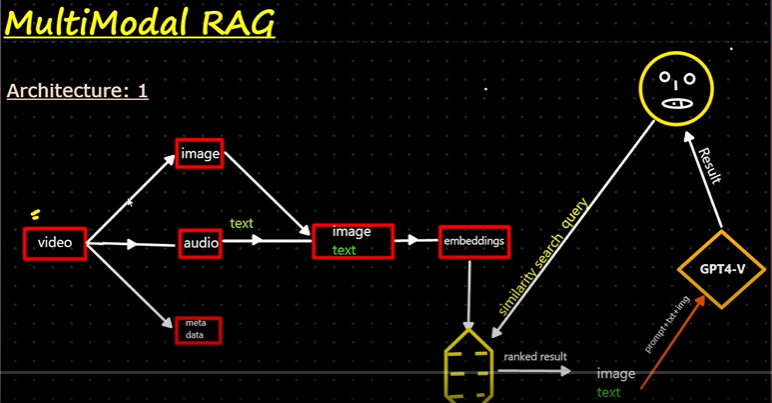

Steps Need to follow:
1. Download video from YouTube, process and store it.
2. Build Multi-Modal index and vector store for both texts and images.
3. Retrieve relevant images and context, use both to augment the prompt.
4. Using GPT4V for reasoning the correlations between the input query and augmented data and generating final response.

In [ ]:
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
from moviepy import VideoFileClip

In [6]:
# video_url="https://youtu.be/3dhcmeOTZ_Q"

In [7]:
output_video_path = "video_data/"

In [1]:
# from the video i am going to collect images,audio,text
output_folder = "mixed_data/"
output_audio_path = "mixed_data/output_audio.wav"

In [9]:
filepath=output_video_path + "llm.mp4"
# filepath = output_audio_path + "input_vid.mp4"
print(filepath)

video_data/llm.mp4


In [10]:
from pytube import YouTube

In [12]:
# yt = YouTube(video_url)

In [13]:
# yt.streams.get_highest_resolution().download(
#         output_path=output_video_path, filename="input_vid.mp4"
#     )

In [14]:
# yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download()

In [15]:
# def download_video(url,output_path):
#   yt = YouTube(url)
#   metadata = {"Author": yt.author, "title": yt.title, "Length": yt.length, "Views": yt.views}

#   yt.streams.get_highest_resolution().download(
#         output_path=output_path, filename="input_vid.mp4"
#     )
  
#   # yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download()
  
#   return metadata

In [16]:
# metadata_vid = download_video(video_url, output_video_path)

In [17]:
import os

In [18]:
def video_to_images(video_path,output_folder):
  clip=VideoFileClip(video_path)
  clip.write_images_sequence(
      os.path.join(output_folder,"frame%04d.png"),fps=0.2 # frame per second
  )

In [20]:
video_to_images(filepath,output_folder)

In [24]:

def video_to_audio(video_path,output_audio_path):
  clip=VideoFileClip(video_path)
  audio=clip.audio
  audio.write_audiofile(output_audio_path)

In [ ]:
video_to_audio(filepath,output_audio_path)

In [21]:

def audio_to_text(audio_path):
  recognizer=sr.Recognizer()
  audio=sr.AudioFile(audio_path)

  with audio as source:
    audio_data=recognizer.record(source)

    try:

      #recognize the speech
      text = recognizer.recognize_whisper(audio_data)

    except sr.UnknownValueError:
      print("Speech recognition could not understand the audio.")
  return text

In [3]:
import whisper

In [ ]:
text_data=audio_to_text(output_audio_path)

100%|███████████████████████████████████████| 139M/139M [00:21<00:00, 6.91MiB/s]
d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\whisper\__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relate

In [25]:

with open(output_folder + "output_text.txt", "w") as file:
        file.write(text_data)
print("Text data saved to file")
file.close()

Text data saved to file


In [ ]:
# os.remove(output_audio_path)
# print("Audio file removed")

In [2]:

from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader
from llama_index.core import StorageContext

In [3]:

from llama_index.vector_stores.lancedb import LanceDBVectorStore

d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#InmemoryVectorStore
text_store=LanceDBVectorStore(uri="lancedb",table_name="text_collection")
image_store=LanceDBVectorStore(uri="lancedb",table_name="image_collection")

In [4]:
text_store

LanceDBVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, uri='lancedb', vector_column_name='vector', nprobes=20, refine_factor=None, text_key='text', doc_id_key='doc_id', api_key=None, region=None, mode='overwrite', query_type='vector', overfetch_factor=1)

In [5]:
image_store

LanceDBVectorStore(stores_text=True, is_embedding_query=True, flat_metadata=True, uri='lancedb', vector_column_name='vector', nprobes=20, refine_factor=None, text_key='text', doc_id_key='doc_id', api_key=None, region=None, mode='overwrite', query_type='vector', overfetch_factor=1)

In [ ]:
storage_context=StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

In [31]:
# creating a StorageContext object, which is used to manage the storage of vectors and metadata in a vector database.
# StorageContext:
# StorageContext is a class that provides a unified interface for storing and retrieving vectors and metadata.
# from_defaults method:
# The from_defaults method creates a new StorageContext object with default settings.
# Parameters:
# vector_store: The vector store to use for storing vectors. In this case, you're using text_store as the default vector store.
# image_store: The vector store to use for storing image vectors. In this case, you're using image_store as the default image store.

In [6]:
documents=SimpleDirectoryReader(output_folder).load_data()

In [4]:
import torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "d:

In [35]:
torch.from_numpy([1, 2, 3])

RuntimeError: Numpy is not available

In [5]:
torch.__version__

'2.2.2+cpu'

In [6]:
import clip

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
OPENAI_API_TOKEN=os.getenv('OPENAI_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [27]:
# GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")  # add your GOOGLE API key here
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [28]:
# imports
# from llama_index.embeddings.gemini import GeminiEmbedding

In [18]:
from llama_index.core import Settings

In [29]:

# model_name = "models/embedding-001"

In [30]:
# Settings.embed_model = GeminiEmbedding(model_name=model_name, api_key=GOOGLE_API_KEY)

In [21]:
import numpy

In [22]:
numpy.__version__

'2.0.2'

In [26]:
import torch

# Assuming all_embeddings is a list of lists
all_embeddings = [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]

# Convert the list of lists to a list of PyTorch tensors
all_embeddings = [torch.tensor(embedding) for embedding in all_embeddings]

print(all_embeddings)

[tensor([1., 2., 3.]), tensor([4., 5., 6.])]


use opneai key for openai embedding

get numpy issue for huggingface embedding and gemini embedding 

get warnings from torch before

In [ ]:
index = MultiModalVectorStoreIndex.from_documents(documents,storage_context=storage_context)

Retrying llama_index.embeddings.openai.base.OpenAIEmbedding._get_text_embeddings.<locals>._retryable_get_embeddings in 1.0 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}.


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
retriever_engine=index.as_retriever(similarity_top_k=1, image_similarity_top_k=5)

In [ ]:

from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

In [ ]:
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

In [ ]:
query = " what is llm ?"

In [ ]:
img,text=retrieve(retriever_engine,query)

In [ ]:

import matplotlib.pyplot as plt
def plot_images(images_path):
  images_shown = 0
  plt.figure(figsize=(16, 9))
  for img_path in images_path:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 5:
                break

In [ ]:

qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [ ]:
import json
# metadata_str=json.dumps(metadata_vid)

In [ ]:
context_str = "".join(text)

In [ ]:
query_str =""

In [ ]:
image_documents = SimpleDirectoryReader( input_files=img).load_data()


from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500)

result=openai_mm_llm.complete(
    prompt=qa_tmpl_str.format(
        query_str=query_str,metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

pprint(result.text)

qa_tmpl_str=(
    "Based on the provided information, including relevant images and retrieved context from the video, \
    accurately and precisely answer the query without any additional prior knowledge.\n"

    "---------------------\n"
    "Metadata for video: {metadata_str} \n"

    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)